In [14]:
import json
import requests
import websockets
from requests import Session
import time
import hashlib
import hmac
import base64
import sys
import numpy as np
import matplotlib.pyplot as plt
inf = sys.maxsize

# Websocket Connection Setup

In [15]:
url = 'https://api.kucoin.com/api/v1/bullet-public'

In [16]:
x = requests.post(url)

In [17]:
cjson = json.loads(x.text)

In [18]:
endpoint = cjson['data']['instanceServers'][0]['endpoint']
token = cjson['data']['token']

In [19]:
multi = {"id": "1Jpg30DEdU", "type": "openTunnel", "newTunnelId": "bt1", "response": False}
# command used to open tunnel

In [9]:
multi_spotEth = {"id": "1JpoPamgFM",
             "type": "subscribe",
             "topic": "/market/ticker:ETH-USDT",
             "tunnelId": "bt1", "response": False}
# subscriptions to websocket with tunnelID attached

In [10]:
multi_futureEth = {"id": 1545910660740,                          
                "type": "subscribe",
                "topic": "/contractMarket/tickerV2:ETHUSDTM",
                "tunnelId": "bt1", "response": False}
# subscriptions to websocket with tunnelID attached

In [11]:
import sys
sys.path.append('..')
import classified

# for future api
fapi_passphrase = classified.FPASSPHRASE
fapi_key = classified.FKEY
fapi_secret = classified.FSECRET
# for spot api
api_passphrase = classified.SPASSPHRASE
api_key = classified.SKEY
api_secret = classified.SSECRET

session = Session()

In [12]:
def auth(method, endpoint):
    now = int(time.time() * 1000)
    str_to_sign = str(now) + method.upper() + endpoint
    signature = base64.b64encode(
        hmac.new(api_secret.encode('utf-8'), str_to_sign.encode('utf-8'), hashlib.sha256).digest())
    passphrase = base64.b64encode(hmac.new(api_secret.encode('utf-8'), api_passphrase.encode('utf-8'), hashlib.sha256).digest())
    headers = {
        "KC-API-SIGN": signature,
        "KC-API-TIMESTAMP": str(now),
        "KC-API-KEY": api_key,
        "KC-API-PASSPHRASE": passphrase,
        "KC-API-KEY-VERSION": '2',
        "Content-Type": "application/json"
    }
    return headers

# Sort Data From Websocket

In [13]:
spotPrices = np.array([])
futurePrices = np.array([])
differences = np.array([])
async with websockets.connect(endpoint+"?token="+token) as conn:
    await conn.send(json.dumps(multi))  # initial open tunel command
    res = await conn.recv()
    
    await conn.send(json.dumps(multi_spotEth)) # send tunnel subscription
    res = await conn.recv()
    await conn.send(json.dumps(multi_futureEth))  # send tunnel subscription
    res = await conn.recv()
    
    counter = 0
    spotPrice = 0
    futurePrice = 0
    while True and counter < inf:
        res = await conn.recv()
        vals = json.loads(res)

        if (vals['topic']) == '/contractMarket/tickerV2:ETHUSDTM':
#             print(f"Future Price is: {vals['data']['bestAskPrice']}")
            futurePrice = float(vals['data']['bestAskPrice'])
            futurePrices.append(futurePrice)

        elif (vals['topic']) == '/market/ticker:ETH-USDT':
#             print(f"Spot Price is: {vals['data']['bestAsk']}")
            spotPrice = float(vals['data']['bestAsk'])
            spotPrices.append(spotPrice)
        
        difference = spotPrice - futurePrice
        differences.append(difference)
        print(spotPrice - futurePrice)
        print(counter)
        
        # OPEN POSTION
        if spotPrice - futurePrice > 1 and futurePrice != 0 and spotPrice != 0:
            print('Long Future and Short Spot')
            
        elif futurePrice - spotPrice > 1 and futurePrice != 0 and spotPrice != 0:
            print('Long Spot and Short Future')
#             arb.arbOpen(spotPrice, futurePrice)
            
            
        counter += 1
    eth_tunnel = {"id": "1JpoPamgFM", "type": "closeTunnel", "tunnelId": "bt1", "response": False}            
    btc_tunnel = {"id": "1JpoPamgFN", "type": "closeTunnel", "tunnelId": "bt1", "response": False}
    await conn.send(json.dumps(eth_tunnel))
    await conn.send(json.dumps(btc_tunnel))
    await conn.close()

NameError: name 'endpoint' is not defined

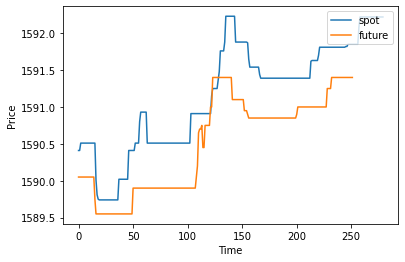

In [16]:
plt.plot(spotPrices, label="spot")
plt.plot(futurePrices, label="future")
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend(loc="upper right")
plt.show()

In [17]:
differences = [i for i in differences if i > 0]

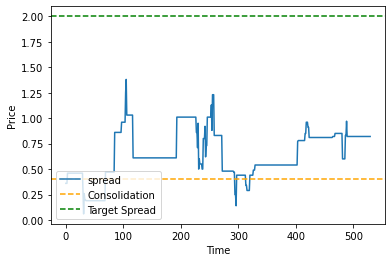

In [18]:
differences.pop(0)
plt.plot(differences, label="spread")
plt.axhline(y=0.4, color='orange', linestyle='--', label="Consolidation")
plt.axhline(y=2, color='green', linestyle='--', label="Target Spread")
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend(loc="lower left")
plt.show()